In [28]:
%matplotlib inline

import sys
import os
sys.path.append('C:/Users/samrari/ComputBuffer')

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from skimage import exposure, img_as_float, morphology
from PIL import Image

from osgeo import gdal
import osr
import xml.etree.ElementTree as ET
from my_packages.My_Geoprocess import*

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import KMeans
from datetime import datetime


In [177]:
Ncluster = 8
Footprint = 'all'

In [285]:
MaskPath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/'
shapefile_path = ["D:/testInterp/error.shp"]

SoilIndex = gdal.Open( MaskPath+'10m.tif')
cols = SoilIndex.RasterXSize
rows = SoilIndex.RasterYSize
geo_transform = SoilIndex.GetGeoTransform()
proj = SoilIndex.GetProjectionRef()
del SoilIndex

'''CompoPath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/GRANULE/L1C_T58KFA_A010823_20170718T231219/IMG_DATA/Deglinted/Compo.tif'
Compo = gdal.Open(CompoPath)
CompoBands = np.full((rows, cols, 3), np.NaN, np.uint16)
CompoBands = np.dstack((Compo.GetRasterBand(1).ReadAsArray(),\
                     Compo.GetRasterBand(2).ReadAsArray(),\
                     Compo.GetRasterBand(3).ReadAsArray()))'''

errors = vectors_to_raster(shapefile_path, rows, cols, geo_transform, proj)



In [31]:
npzfile = np.load('TrainMatrix_all.npz')
TX, ClassifIndex = npzfile['arr_0'], npzfile['arr_1']

In [32]:
errors = errors==1

In [33]:
TX.shape

(20765849, 11)

In [34]:
Im = np.full((ClassifIndex.shape[0],ClassifIndex.shape[1],TX.shape[1]), np.NaN, TX.dtype)
Im[ClassifIndex] = TX
ClassifIndex[errors] = False
print(TX.shape)
TX = Im[ClassifIndex]
print(TX.shape)
del Im

(20765849, 11)
(20745809, 11)


In [8]:
scaler = preprocessing.StandardScaler().fit(TX)
TX = np.array(scaler.transform(TX))

In [35]:
np.mean(TX, axis=0)


array([ -0.23852866,  -4.63836089, -12.701999  ,  -7.9303911 ,
        -3.59495069,  -9.3299396 ,  -5.45863511,  -2.40812257,
        -0.39222544,   1.4023531 ,   0.07714932])

In [36]:
np.std(TX, axis=0)

array([ 0.36455387,  0.95512315,  1.82614055,  3.10746637,  0.79421928,
        1.41927458,  2.50394125,  0.43367454,  1.19026968,  0.61569969,
        0.02086536])

In [178]:
class1 = 'KmeansClassif_'+str(Ncluster)+'Train1.1'+'.tif'

test = gdal.Open( 'Classif2/'+class1)
Classif = test.GetRasterBand(1).ReadAsArray()

In [179]:

Y = Classif[ClassifIndex]

In [150]:
clustersCent = np.asarray([np.mean(TX[Y==i], axis=0) for i in range(1,len(np.unique(Classif)))])

In [180]:
np.unique(Classif)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint16)

In [182]:
Nombre8

array([ 915780, 1104623, 3906250, 2996513, 3709886, 6015906, 1090638,
       1006213])

In [55]:
def my_dist(x1,x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))
my_dist(clustersCent[0,:],clustersCent[1,:])


18.843593201892816

In [157]:
def my_dist(x1,x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

Distance_mat = np.full((Ncluster,Ncluster), np.nan, np.float)
for i in range(Ncluster):
    for i2 in range(Ncluster):
        Distance_mat[i,i2] = my_dist(clustersCent[i,:], clustersCent[i2,:])

In [191]:
np.sum(np.multiply(score, Nombre8)) / np.sum(Nombre8)

0.62257919949036455

In [188]:
score3L = np.array([0.85,0.73,0.61])

In [189]:
np.sum(np.multiply(score3L, Nombre3)) / np.sum(Nombre3)

0.68187457090730952

In [187]:
np.sum(np.multiply(score2, Nombre8)) / np.sum(Nombre8)

0.58432763070362792

In [66]:
def bmatrix(a):
    text = r'$\left[\begin{array}{*{'
    text += str(len(a[0]))
    text += r'}c}'
    text += '\n'
    for x in range(len(a)):
        for y in range(len(a[x])):
            if np.isnan(a[x][y]):
                text += '-'
            else:
                text += str(a[x][y])
            text += r' & '
        text = text[:-2]
        text += r'\\'
        text += '\n'
    text += r'\end{array}\right]$'

    print(text)
bmatrix(Distance_mat)

$\left[\begin{array}{*{8}c}
0.0 & 18.8435932019 & 7.73713566796 & 14.4910239634 & 6.22455418583 & 10.4327051994 & 4.4011059891 & 10.0841007001 \\
- & 0.0 & 11.3632936752 & 4.46688814319 & 12.6824499755 & 8.55136492478 & 18.754117233 & 9.25322739726 \\
- & - & 0.0 & 6.91862590292 & 2.61536149492 & 2.83186897938 & 9.1221447589 & 2.55226801899 \\
- & - & - & 0.0 & 8.4211015369 & 4.12143813858 & 14.800327265 & 4.83364952606 \\
- & - & - & - & 0.0 & 4.54811095973 & 6.73604017582 & 4.53502011425 \\
- & - & - & - & - & 0.0 & 11.2098489623 & 1.39976150359 \\
- & - & - & - & - & - & 0.0 & 11.2033678899 \\
- & - & - & - & - & - & - & 0.0 \\
\end{array}\right]$


In [94]:
import pandas as pd
pd.DataFrame(Distance_mat).to_latex(na_rep='-', float_format='%.2f')

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &   0 &     1 &     2 &     3 &     4 &     5 &     6 &     7 \\\\\n\\midrule\n0 & 0.0 & 18.84 &  7.74 & 14.49 &  6.22 & 10.43 &  4.40 & 10.08 \\\\\n1 &   - &  0.00 & 11.36 &  4.47 & 12.68 &  8.55 & 18.75 &  9.25 \\\\\n2 &   - &     - &  0.00 &  6.92 &  2.62 &  2.83 &  9.12 &  2.55 \\\\\n3 &   - &     - &     - &  0.00 &  8.42 &  4.12 & 14.80 &  4.83 \\\\\n4 &   - &     - &     - &     - &  0.00 &  4.55 &  6.74 &  4.54 \\\\\n5 &   - &     - &     - &     - &     - &  0.00 & 11.21 &  1.40 \\\\\n6 &   - &     - &     - &     - &     - &     - &  0.00 & 11.20 \\\\\n7 &   - &     - &     - &     - &     - &     - &     - &  0.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [121]:
print(pd.DataFrame(Distance_mat, columns = ['Class 1','Class 2','Class 3'], index = ['Class 1','Class 2','Class 3']).to_latex(longtable = False ,na_rep='-', float_format='%.2f'))

\begin{tabular}{lrrr}
\toprule
{} &  Class 1 &  Class 2 &  Class 3 \\
\midrule
Class 1 &      0.0 &    13.26 &     6.57 \\
Class 2 &        - &     0.00 &     7.09 \\
Class 3 &        - &        - &     0.00 \\
\bottomrule
\end{tabular}



In [250]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

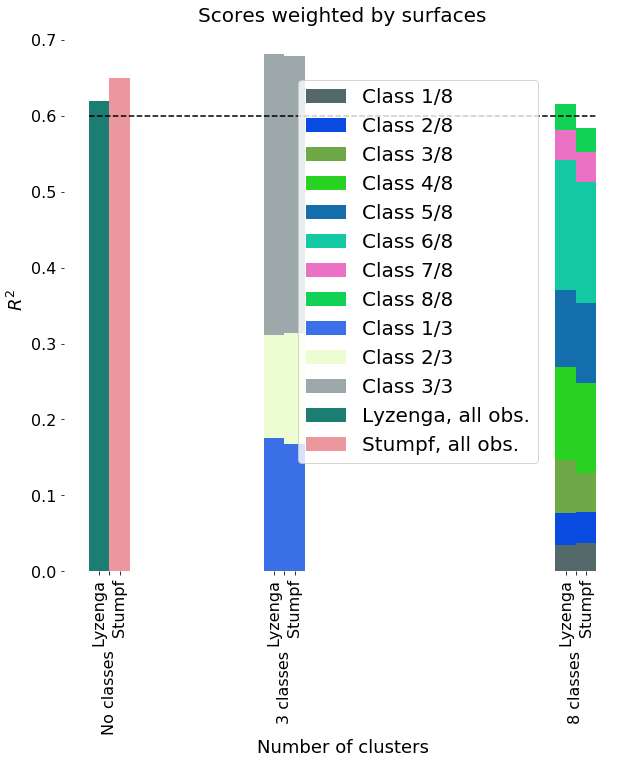

In [278]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10,10))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

N = 6
width = 0.35 
c=np.random.rand(8,3)
c2=np.random.rand(3,3)

Score8L = (0.77,0.80,0.37,0.85,0.57,0.59,0.75,0.71)
Score8S = (0.84,0.78,0.27,0.82,0.59,0.55,0.75,0.66)
Score3L = (0.85,0.73,0.61)
Score3S = (0.81,0.79,0.60)

BarL8 = np.multiply(Score8L, Nombre8/ np.sum(Nombre8))
CumL8 = np.cumsum(BarL8)
for i in range(1,9):
    if i == 1 :
        bar8 = plt.bar(8-width/2,BarL8[i-1], width ,color=c[i-1], bottom=0, label='Class '+str(i)+'/8')
    else:
        bar8 = plt.bar(8-width/2,BarL8[i-1], width ,color=c[i-1], bottom=CumL8[i-2], label='Class '+str(i)+'/8')
        
BarL3 = np.multiply(Score3L, Nombre3/ np.sum(Nombre3))
CumL3 = np.cumsum(BarL3)
for i in range(1,4):
    if i == 1 :
        plt.bar(3-width/2,BarL3[i-1], width ,color=c2[i-1], bottom=0, label='Class '+str(i)+'/3')
    else:
        plt.bar(3-width/2,BarL3[i-1], width ,color=c2[i-1], bottom=CumL3[i-2], label='Class '+str(i)+'/3')
        
plt.bar(0-width/2,0.62, width ,color=np.random.rand(3,), bottom=0, label='Lyzenga, all obs.')
plt.bar(0+width/2,0.65, width ,color=np.random.rand(3,), bottom=0, label='Stumpf, all obs.')
plt.legend(loc=(0.42,0.2), fontsize=20) 
BarS8 = np.multiply(Score8S, Nombre8/ np.sum(Nombre8))
CumS8 = np.cumsum(BarS8)
for i in range(1,9):
    if i == 1 :
        plt.bar(8+width/2,BarS8[i-1], width ,color=c[i-1], bottom=0, label='Class '+str(i)+'/8')
    else:
        plt.bar(8+width/2,BarS8[i-1], width ,color=c[i-1], bottom=CumS8[i-2], label='Class '+str(i)+'/8')


BarS3 = np.multiply(Score3S, Nombre3/ np.sum(Nombre3))
CumS3 = np.cumsum(BarS3)
for i in range(1,4):
    if i == 1 :
        plt.bar(3+width/2,BarS3[i-1], width ,color=c2[i-1], bottom=0, label='Class '+str(i)+'/3')
    else:
        plt.bar(3+width/2,BarS3[i-1], width ,color=c2[i-1], bottom=CumS3[i-2], label='Class '+str(i)+'/3')

plt.xticks([0-width/2, 0, 0+width/2, 3-width/2, 3, 3+width/2, 8-width/2, 8, 8+width/2],\
           ['Lyzenga','No classes              ', 'Stumpf', 'Lyzenga','3 classes              ', 'Stumpf', 'Lyzenga','8 classes              ', 'Stumpf'],\
          fontsize =16, rotation=90)
plt.title('Scores weighted by surfaces',fontsize=20)        
plt.xlabel('Number of clusters',fontsize=18)
plt.ylabel('$R^{2}$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot([0-width ,8+width], [0.6,0.6], 'k--')

In [248]:
np.sum(BarS3)

0.678613972585981

In [283]:
CumS8

array([ 0.03708003,  0.0786116 ,  0.12945018,  0.24789052,  0.35339774,
        0.5128877 ,  0.55231632,  0.58432763])

In [ ]:
    
        
Score8S = (0.84,0.78,0.27,0.82,0.59,0.55,0.75,0.66)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, menMeans, width, color=(0.2588,0.4433,1.0))
p2 = ax.bar(ind, womenMeans, width, color=(1.0,0.5,0.62),
             bottom=menMeans)
ax.set_ylabel('Scores')
ax.set_xlabel('Groups')
ax.set_title('Scores by group and gender')

ax.set_xticks(ind + width/2.)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

plotly_fig = tls.mpl_to_plotly( mpl_fig )

# For Legend
plotly_fig["layout"]["showlegend"] = True
plotly_fig["data"][0]["name"] = "Men"
plotly_fig["data"][1]["name"] = "Women"


In [15]:
npzfile = np.load('TrainMatrixGlob_all.npz')
TX, ClassifIndex = npzfile['arr_0'], npzfile['arr_1']
TX = np.array(scaler.transform(TX))
Im = np.full((ClassifIndex.shape[0],ClassifIndex.shape[1],TX.shape[1]), np.NaN, TX.dtype)
Im[ClassifIndex] = TX
ClassifIndex[errors] = False
print(TX.shape)
TX = Im[ClassifIndex]
print(TX.shape)
del Im

(24675890, 11)
(24655850, 11)


In [286]:
npzfile = np.load('TrainMatrixGlob_all.npz')
ClassifIndex =  npzfile['arr_1']
ClassifIndex[errors] = False


In [16]:
knownKm = KMeans()
knownKm.cluster_centers_ = clustersCent

In [17]:
newY = knownKm.predict(TX)

In [18]:
newY[newY==0]=Ncluster

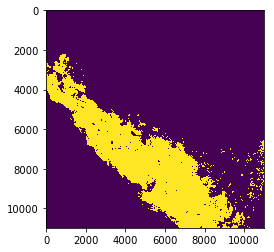

In [287]:
plt.imshow(ClassifIndex)

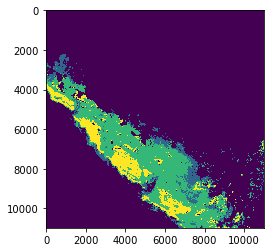

In [20]:
image = np.full(ClassifIndex.shape,0, dtype=np.int8)
image[ClassifIndex]= newY
plt.imshow(image)
MaskPath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/'
SoilIndex = gdal.Open( MaskPath+'10m.tif') 

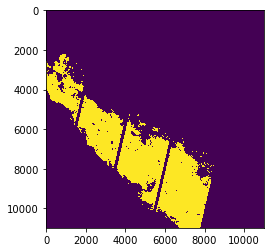

In [284]:
plt.imshow(ClassifIndex)

In [289]:
image = np.full(ClassifIndex.shape,np.nan, dtype=np.float64)
ShomBathy = gdal.Open( 'D:/Data_SHOM/ShomBathyCubicFull.tif')
geo_transform = ShomBathy.GetGeoTransform()
proj = ShomBathy.GetProjectionRef()
ShomBathy = ShomBathy.GetRasterBand(1).ReadAsArray()

index = np.logical_and(ShomBathy <= 35, ClassifIndex)
image[index] = ShomBathy[index]

write_raster2('D:/Data_SHOM/ShomBathyPYClip.tif', image, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_Float64)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


In [21]:

class1 = 'Classif/Full'+title

test = gdal.Open('Classif2/Full'+title)
Classif = test.GetRasterBand(1).ReadAsArray()
geo_transform = test.GetGeoTransform()
proj = test.GetProjectionRef()
rows, cols = test.RasterXSize , test.RasterYSize

FootprintFilePath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/FootPrint/'

for File in GetSimpleFiles("B02_11.shp", directory=FootprintFilePath):
    print(File)
    FP = create_mask_from_vector(FootprintFilePath + File, cols, rows, geo_transform, \
                                             proj, target_value=1, format=gdal.GDT_Byte)
    FP = FP.GetRasterBand(1).ReadAsArray().astype(bool)
    

Classif[FP==True] = 0
write_raster2('Classif2/Full'+title, Classif, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_UInt16)

B02_11.shp


In [26]:
title = 'KmeansClassif_'+str(Ncluster)+'Train1.1'+'.tif'
class1 = 'Classif/Full'+title  

test = gdal.Open('Classif2/Full'+title)
FullClassif = test.GetRasterBand(1).ReadAsArray()

class1 = 'Classif/Full'+title

test = gdal.Open('Classif2/'+title)
Classif = test.GetRasterBand(1).ReadAsArray()

for i in np.unique(Classif):
    print(i, np.sum(Classif==i), np.sum(FullClassif==i))

0 99814591 98814927
1 915780 1156087
2 1104623 4133496
3 3906250 3203490
4 2996513 3743713
5 3709886 6428117
6 6015906 1093801
7 1090638 1039121
8 1006213 947648


In [27]:
Temp = np.full(Classif.shape, 0, Classif.dtype)
Temp[:] = FullClassif[:]
FullClassif[Temp==1] = 2
FullClassif[Temp==2] = 3
FullClassif[Temp==3] = 4
FullClassif[Temp==4] = 5
FullClassif[Temp==5] = 6
FullClassif[Temp==6] = 7
FullClassif[Temp==7] = 8
FullClassif[Temp==8] = 1
write_raster2('Classif2/FullFin'+title, FullClassif, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_UInt16)

In [249]:
451*460000/507

409191.3214990138